# project10 : CIFAR-10 이미지 생성하기
### [루브릭]
1. GAN의 두 모델 구조를 통해 이미지를 성공적으로 생성하였다.
    - 오브젝트 종류를 육안으로 구별할 수 있을 만한 이미지를 생성하였다.
1. 생성 이미지 시각화 및 학습 그래프를 통해 GAN 학습이 바르게 진행되었음을 입증하였다.
    - gif를 통해 생성이미지 품질이 서서히 향상되는 것과, fake accuracy가 추세적으로 0.5를 향해 하향하고 있음을 확인하였다.
1. 추가적인 GAN 모델구조 혹은 학습과정 개선 아이디어를 제안하고 이를 적용하였다.
    - 제출 아이디어를 제출 프로젝트에 반영하고, 그 결과가 아이디어 적용 이전보다 향상되었음을 시각적으로 입증하였다.

### [학습 과정]
1. 작업환경 구성하기
1. 데이터셋 구성하기
1. 생성자 모델 구현하기
1. 판별자 모델 구현하기
1. 손실함수와 최적화 함수 구현하기
1. 훈련과정 상세 기능 구현하기
1. 학습 과정 진행하기
1. (optional) GAN 훈련 과정 개선하기

### [회고]

## 1. 작업환경 구성하기

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt

In [2]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

170508288/170498071 [==============================] - 4s 0us/step


(50000, 32, 32, 3)

## 2. 데이터셋 구성하기

### : 데이터 시각화

In [3]:
train_x[0].shape

(32, 32, 3)

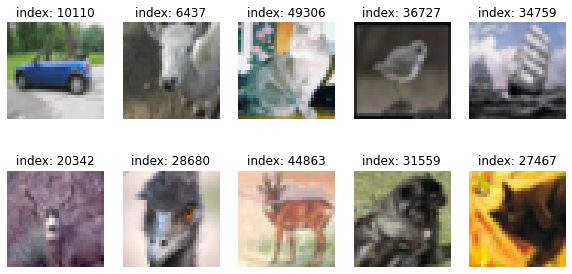

In [4]:
plt.figure(figsize=(10, 5))
for i in range(10):
    rn = np.random.randint(len(train_x))
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[rn])
    plt.title(f'index: {rn}')
    plt.axis('off')
# plt.imshow(train_x[0])
plt.show()

### : 데이터 정규화

In [5]:
train_x.max(), train_x.min()

(255, 0)

In [6]:
train_x = (train_x - 127.5) / 127.5

train_x.max(), train_x.min()

(1.0, -1.0)

In [7]:
train_x[3318].max(), train_x[3318].min()

(0.403921568627451, -1.0)

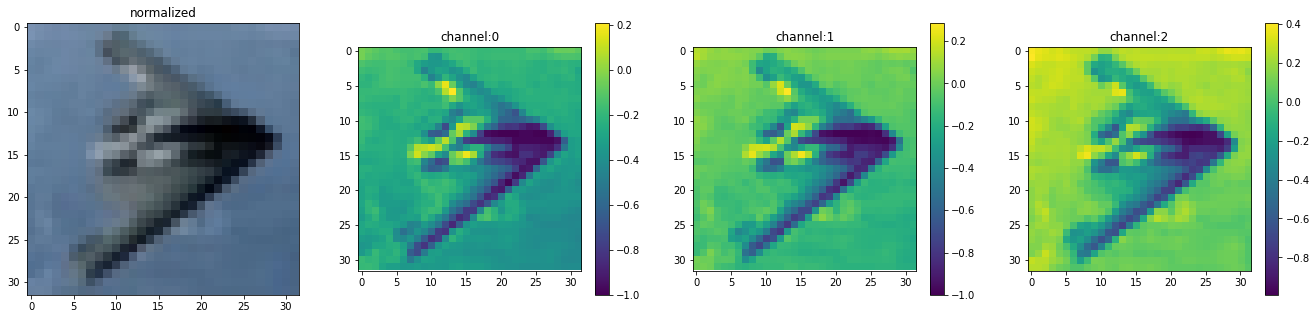

In [8]:
# 정규화 후에 시각화시도 및 채널별 출력
# imshow의 경우 음수의 값은 표현이 안된다고 경고문이 뜰 것이다.
# [-1, 1]의 범위를 다시 [0, 1]로 다시 변환
plt.figure(figsize=(23, 5))

plt.subplot(1, 4, 1)
plt.title("normalized")
plt.imshow((train_x[3318]+1)/2)

for i in range(3):
    plt.subplot(1, 4, (i+1)+1)
    plt.imshow(train_x[3318][:,:,i])
    plt.title('channel:{}'.format(i))
    plt.colorbar()
    
# plt.colorbar()
plt.show()

In [9]:
BUFFER_SIZE = len(train_x)
BATCH_SIZE = 128

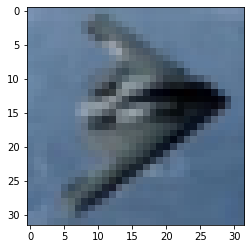

In [10]:
test_img = train_x[3318]
plt.imshow((test_img[:,:,:]+1) / 2)

In [11]:
test_img.shape

(32, 32, 3)

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x, )
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [13]:
test_img = next(iter(train_dataset))

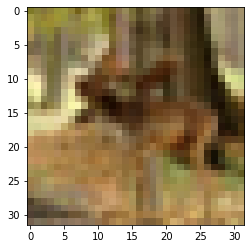

In [14]:
plt.imshow((test_img[0,:,:,:]+1)/2)

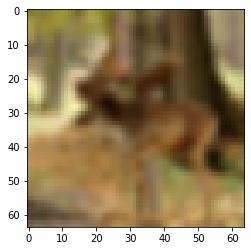

In [15]:
result1 = tf.keras.layers.experimental.preprocessing.Resizing(64, 64, interpolation='bilinear')(test_img)
plt.imshow((result1[0,:,:,:]+1)/2)

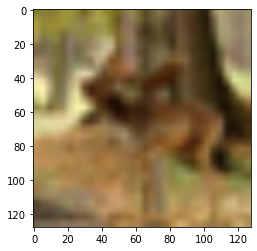

In [16]:
result2 = tf.keras.layers.experimental.preprocessing.Resizing(128, 128)(test_img)
plt.imshow((result2[0,:,:,:]+1)/2)

In [17]:
train_dataset = train_dataset.map(lambda x : tf.keras.layers.experimental.preprocessing.Resizing(64, 64)(x))

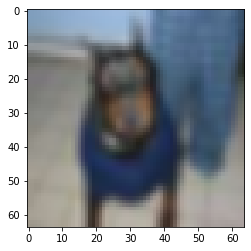

In [18]:
# 데이터셋을 만든 후 데이터 확인
check = next(iter(train_dataset))
plt.imshow((check[0]+1)/2)
plt.show()

## 3. 생성자(Generator) 모델 구현하기

In [19]:
INPUT_SHAPE = (64, 64, 3)

In [20]:
def make_generator_model():
    
    # start
    model = tf.keras.Sequential()
    
    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    # Second: Reshape Layer
    model.add(layers.Reshape((8, 8, 256)))
    
    # Third: Conv2DTranspose layer
#     model.add(layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(1, 1), padding='same', use_bias=False))
#     model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU(alpha=0.2))

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    # Sixth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(256, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False))
#     model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Seventh: Conv2DTranspose layer
    # Color에는 rgb의 3개 채널이 있어야 하기 때문에 3으로 변경
    model.add(layers.Conv2DTranspose(3, kernel_size=(4, 4), padding='same', use_bias=False, activation='tanh'))
    
    return model

In [21]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 128)       524288    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 128)       262144    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 128)       0

(1, 64, 64, 3)
0.014897884 -0.014765244


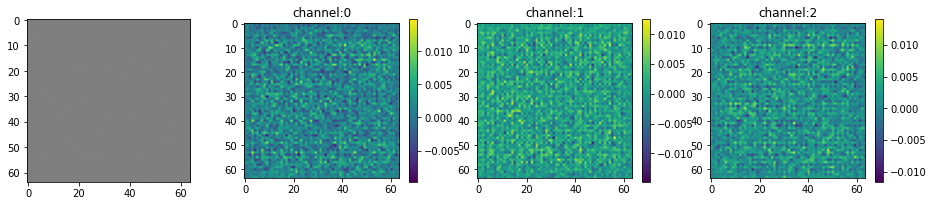

In [22]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
print(generated_image.shape)
print(np.max(generated_image[0]), np.min(generated_image[0]))

plt.figure(figsize=(16, 3))
plt.subplot(1, 4, 1)
plt.imshow((generated_image[0, :, :, :]+1)/2)
for i in range(3) :
    plt.subplot(1, 4, (i+1)+1)
    plt.imshow(generated_image[0, :, :, i])
    plt.title("channel:{}".format(i))
    plt.colorbar()
plt.show()

## 4. 판별자(Discriminator) 모델 구현하기

In [23]:
INPUT_SHAPE

(64, 64, 3)

In [24]:
def make_discriminator_model():
    
    # Start
    model = tf.keras.Sequential()
    
    # First : Conv2D Layer
    model.add(layers.Conv2D(64, (3, 3), padding='same', input_shape=INPUT_SHAPE))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    
    # Second : Conv2D Layer
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    
    # Second : Conv2D Layer
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    
#     Second : Conv2D Layer
    model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    # Third : Flatten Layer
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.4))
    
    # Fourth : Dense Layer
    model.add(layers.Dense(1))

    return model

In [25]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        1792      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 64, 64, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)      

In [26]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.8343795e-05]], dtype=float32)>

## 5. 손실함수와 최적화 함수 구현하기

#### 손실함수

In [27]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [28]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [29]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

#### 정확도 반환 함수

In [30]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

#### 최적화 함수

In [32]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [33]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

## 6. 훈련 과정 상세 기능 설계하기

In [34]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [35]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # generator가 이미지를 생성
        generated_images = generator(noise, training=True)
        
        # discriminator가 실제 입력받은 이미지로는 real_output
        # 위에서 생성한 이미지에 대해서는 fake_output을 계산해서 return
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        # generator의 loss는 fake_output으로만 계산
        # discriminator의 loss는 real_output, fake_output 두 개를 받아서 연산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
        # accuracy계산해서 real, fake에 대한 accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)
        
    # 이부분이 신기하다
    # gradient를 계산하는 부분, gen+tape와 disc_tape를 활용해서 gradient를 자동으로 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    # 위에서 계산된 optimzer에 입력해서 가중치를 갱신
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss, real_accuracy, fake_accuracy

In [36]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # generator가 이미지를 생성
        generated_images = generator(noise, training=True)
        
        # discriminator가 실제 입력받은 이미지로는 real_output
        # 위에서 생성한 이미지에 대해서는 fake_output을 계산해서 return
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        # generator의 loss는 fake_output으로만 계산
        # discriminator의 loss는 real_output, fake_output 두 개를 받아서 연산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
        # accuracy계산해서 real, fake에 대한 accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)
        
    # 이부분이 신기하다
    # gradient를 계산하는 부분, gen+tape와 disc_tape를 활용해서 gradient를 자동으로 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    # 위에서 계산된 optimzer에 입력해서 가중치를 갱신
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss, real_accuracy, fake_accuracy

In [39]:
def generate_and_save_images(model, epoch, it, sample_seeds):
    
    predictions = model(sample_seeds, training=False)
    
    fig = plt.figure(figsize=(4, 4))
    # 이부분을 그려주는게 달라져야 할듯
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i, :, :, :]+1)/2)
        plt.axis('off')
    
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
               .format(os.getenv('HOME'), epoch, it))
    
    plt.show()    

In [40]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

def draw_train_history(history, epoch):
    # summarize history for loss
    plt.subplot(211)
    plt.plot(history['gen_loss'])
    plt.plot(history['disc_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('batch iters')
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')
    
    # summarize history for accuracy
    plt.subplot(212)
    plt.plot(history['fake_accuracy'])
    plt.plot(history['real_accuracy'])
    plt.title('discriminator accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('batch iters')
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지파일로 저장한다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04}.png'
               .format(os.getenv("HOME"), epoch))
    plt.show()
    

In [41]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## 7. 학습 과정 진행하기

In [42]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}
    
    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)
            
            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time() - epoch_start)))
                
        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            
        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time() - start)))
        
        draw_train_history(history, epoch)

In [43]:
save_every = 10
EPOCHS = 100

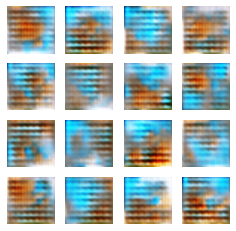

Time for training : 16266 sec


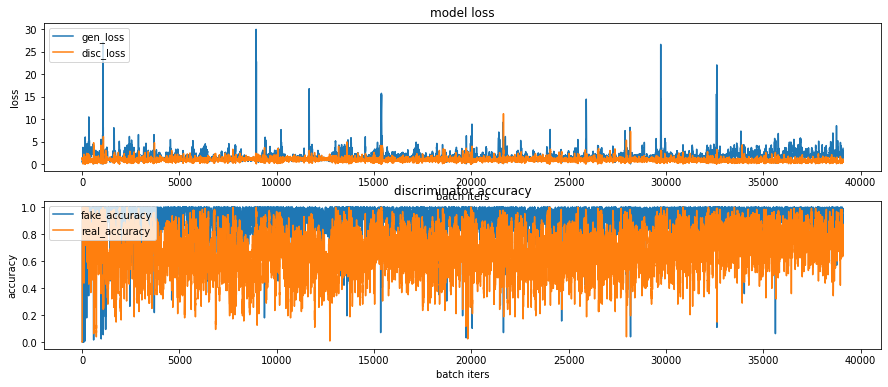

CPU times: user 4h 55min 56s, sys: 12min 36s, total: 5h 8min 33s
Wall time: 4h 31min 8s


In [44]:
%%time
train(train_dataset, EPOCHS, save_every)

In [45]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif

-rw-r--r-- 1 root root 2118723 Feb 15 13:34 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif


## 8. GAN 훈련 과정 개선하기

# [회고]

 이번 프로젝트에서는 GAN을 사용하여 새로운 CIFAR10 이미지를 생성해보았습니다. fake accuracy가 0.5를 향해 가도록 추세를 만드는 것과 gif 이미지가 변화하면서 발전하는 이미지를 만드는 것이 목표였는데, 처음보다는 이미지가 서서히 품질은 좋아졌으나 좋은 이미지가 생성되었다고 할 수 없는 결과가 나왔습니다.  

 GAN 생성자, 판별자 모델을 설계하고 train 하면서 했던 생각은 '생각보다 성능이 좋은지 모르겠다'입니다. 분명 더 좋은 결과를 얻을 수 있을 것 같은데, 한번 모델을 train하는 시간이 오래 걸리다보니 여러번 시도를 못해본 점이 아쉽습니다.  
 
 GAN 성능을 높이는 방법으로는 다음과 같은 것들이 있습니다.

- Normalize inputs to the range [-1, 1] and use tanh in the generator output.
- Flip the labels and loss function when training the generator.
- Sample Gaussian random numbers as input to the generator.
- Use mini batches of all real or all fake for calculating batch norm statistics.
- Use Leaky ReLU in the generator and discriminator.
- Use Average pooling and stride for downsampling; use ConvTranspose2D and stride for upsampling.
- Use label smoothing in the discriminator, with small random noise.
- Add random noise to the labels in the discriminator.
- Use DCGAN architecture, unless you have a good reason not to.
- A loss of 0.0 in the discriminator is a failure mode.
- If loss of the generator steadily decreases, it is likely fooling the discriminator with garbage images.
- Use labels if you have them.
- Add noise to inputs to the discriminator and decay the noise over time.
- Use dropout of 50 percent during train and generation. 